In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, ListedColormap
import cellxgene_census
import textwrap

In [2]:
top_n_embedding = 30

In [3]:
data_dir = "/d/hpc/projects/FRI/DL/mo6643/MSC/data/data_update_slack/"
data = f"data_splits/embedding_cell_type/Homo_sapiens/homo_sapiens_census_top{str(top_n_embedding)}_embedding.h5ad"

In [4]:
adata = sc.read_h5ad(data_dir+data)

In [5]:
dataset_ct_crosstab = pd.crosstab(adata.obs.dataset_id, adata.obs.cell_type)

In [6]:
len(adata.obs.cell_type.unique())

80

In [7]:
census = cellxgene_census.open_soma()
census_datasets = census["census_info"]["datasets"].read().concat().to_pandas()

# for convenience, indexing on the soma_joinid which links this to other census data.
census_datasets = census_datasets.set_index("soma_joinid")

The "stable" release is currently 2023-07-25. Specify 'census_version="2023-07-25"' in future calls to open_soma() to ensure data consistency.


In [8]:
# Create a mapping dictionary
mapping_dict = dict(zip(census_datasets['dataset_id'], census_datasets['dataset_title']))

# Replace the index
dataset_ct_crosstab.index = dataset_ct_crosstab.index.map(mapping_dict)

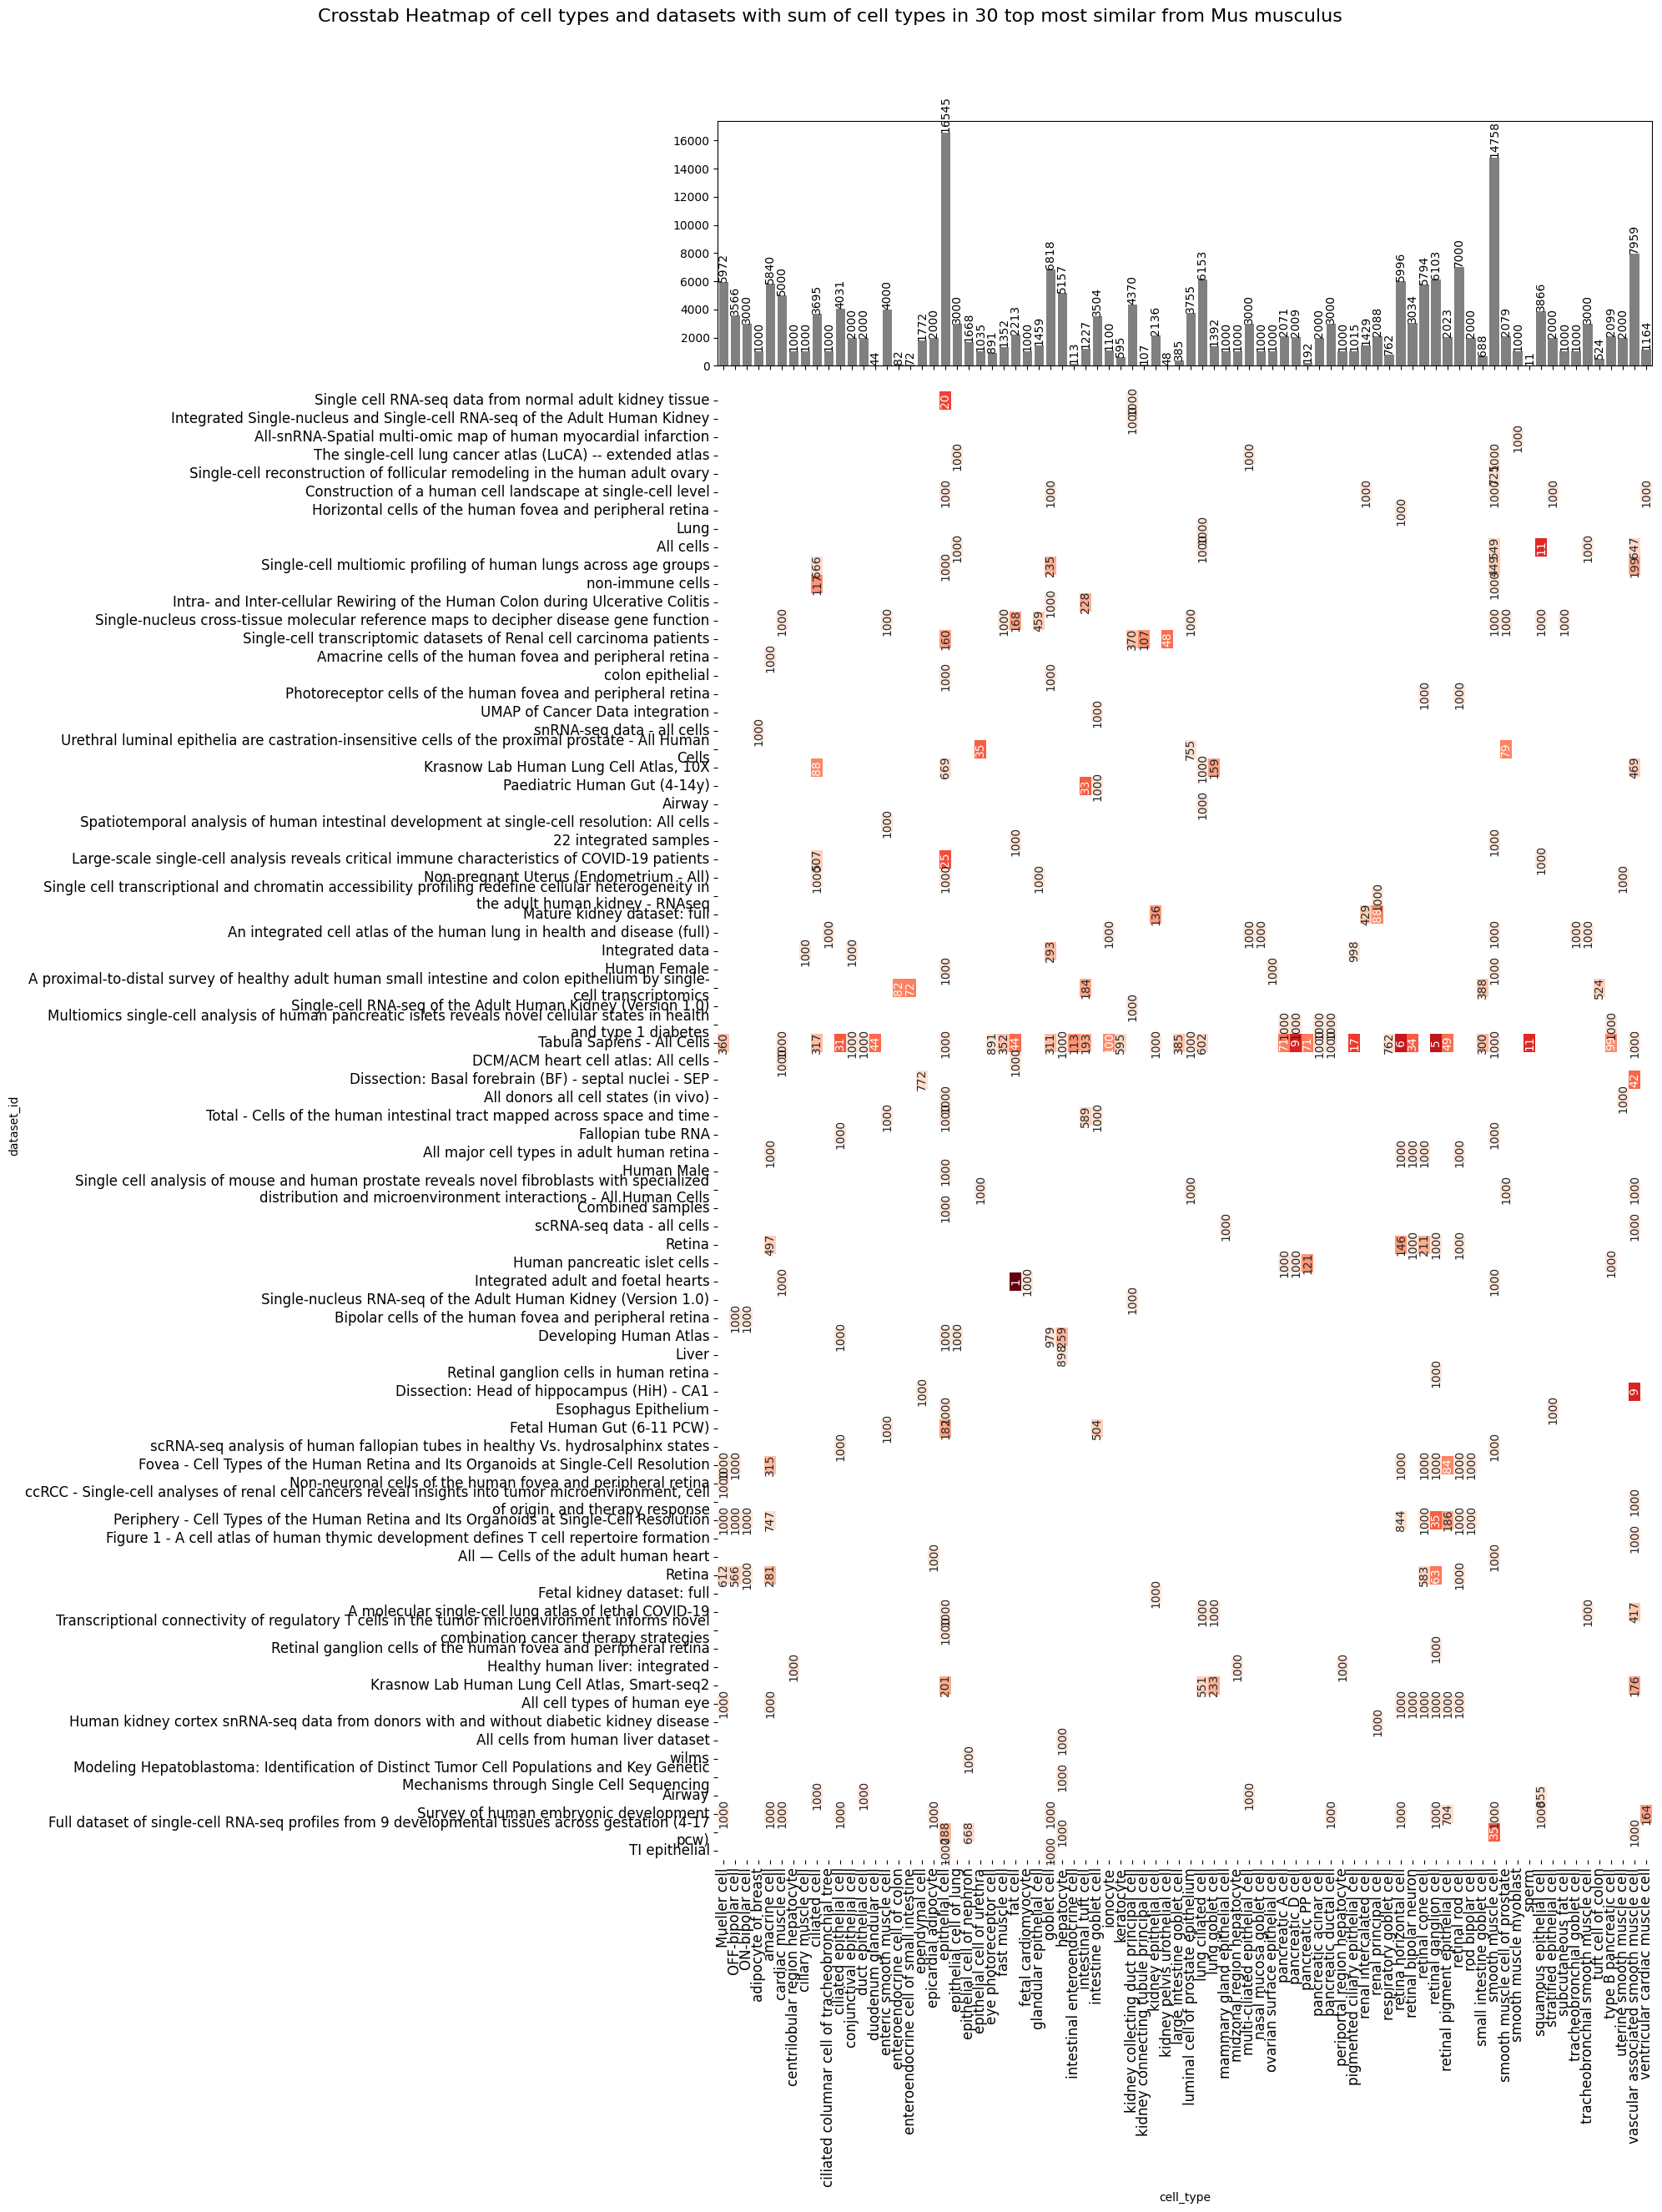

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap
import numpy as np

# Create a mask for zero values
zero_mask = (dataset_ct_crosstab == 0)

# Create a new figure with custom size and subplot layout
fig, (ax_bar, ax_heat) = plt.subplots(2, 1, figsize=(20, 27), gridspec_kw={"height_ratios": [1, 6]}, sharex=True)

# Reverse the Reds colormap
reverse_reds = plt.cm.Reds(np.linspace(1, 0, 256))
reverse_reds_cmap = ListedColormap(reverse_reds)

# Create the heatmap
# Using inverted LogNorm to emphasize smaller values
sns.heatmap(dataset_ct_crosstab, annot=True, fmt='g', mask=zero_mask, cmap=reverse_reds_cmap, cbar=False,
            norm=LogNorm(vmin=1, vmax=2000),  # LogNorm, but colormap is reversed
            annot_kws={"size": 10}, ax=ax_heat)  # Adjust annotation size

# Rotate annotations
for text in ax_heat.texts:
    text.set_rotation(90)

# Create the rotated bar chart for sums of cell types
cell_type_sums = dataset_ct_crosstab.sum(axis=0)
x_positions = np.arange(len(cell_type_sums))  # Generate x positions
offset = 0.5  # Define the offset
bars = ax_bar.bar(x_positions + offset, cell_type_sums.values, color='grey')

# Add numbers on top of the bars
for bar in bars:
    height = bar.get_height()
    ax_bar.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), 
                va='bottom', ha='center', fontsize=10, rotation=90)

# Adjust label size
ax_heat.set_xticklabels(ax_heat.get_xticklabels(), fontsize=12)
wrapped_labels = [textwrap.fill(label.get_text(), width=100) for label in ax_heat.get_yticklabels()]
ax_heat.set_yticklabels(wrapped_labels, fontsize=12)

plt.suptitle(f'Crosstab Heatmap of cell types and datasets with sum of cell types in {str(top_n_embedding)} top most similar from Mus musculus', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the title
plt.savefig(f"figures/dataset_integration_num_of_cells_check_top{str(top_n_embedding)}.png")
plt.show()

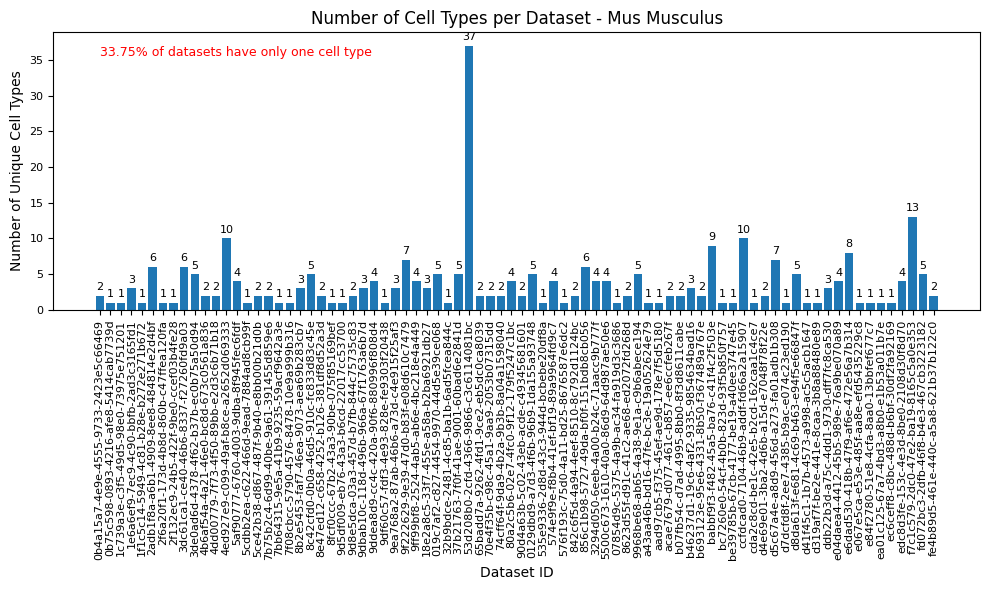

In [12]:
import matplotlib.pyplot as plt

# Assuming adata is already loaded

# Collect dataset names and their counts of unique cell types
dataset_names = []
unique_cell_counts = []

for group_name, group in adata.obs.groupby("dataset_id"):
    dataset_names.append(group_name)
    unique_cell_counts.append(len(group["cell_type"].unique()))

# Calculate the percentage of datasets with only one unique cell type
single_cell_type_percentage = (unique_cell_counts.count(1) / len(dataset_names)) * 100

# Plotting
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
bars = plt.bar(dataset_names, unique_cell_counts)

plt.xlabel('Dataset ID', fontsize=10)
plt.ylabel('Number of Unique Cell Types', fontsize=10)
plt.title('Number of Cell Types per Dataset - Mus Musculus', fontsize=12)
plt.xticks(rotation=90, fontsize=8)  # Rotate x labels and adjust font size
plt.yticks(fontsize=8)  # Adjust y tick font size

# Annotating bars with their values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval,2), ha='center', va='bottom', fontsize=8)

# Display the percentage of datasets with only one unique cell type
plt.text(0.05, 0.95, f"{single_cell_type_percentage:.2f}% of datasets have only one cell type", 
         transform=plt.gca().transAxes, fontsize=9, color='red', va='top')  # TransAxes means the coordinates are given relative to the axes bounding box

plt.tight_layout()  # Ensure no clipping of labels
plt.savefig(f"figures/dataset_num_cell_types_per_dataset_mus_musculus_top{str(top_n_embedding)}.png")
plt.show()
